In [3]:
import datetime
print(f"the date is {datetime.datetime.now()}")

the date is 2025-06-11 10:47:28.024128


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.datasets import fetch_openml # Import fetch_openml

# Load and inspect the dataset
adult_data = fetch_openml(name='adult', version=2, as_frame=True)
df_customer = adult_data.frame

# Check data types before processing
print("Original dtypes:")
print(df_customer.dtypes)
print("\nObject columns:", df_customer.select_dtypes(include=['object']).columns.tolist())

# Handle missing values first
df_customer = df_customer.replace('?', np.nan).dropna()

# Separate features and target
X = df_customer.drop('class', axis=1)
y = df_customer['class']

# Convert ALL categorical columns to dummy variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns # Include 'category' dtype
X_processed = pd.get_dummies(X, columns=categorical_cols, dtype=int, drop_first=True)

# Ensure all columns are numeric by converting everything, coercing errors
# This step is more robust than just checking for 'object' dtype
for col in X_processed.columns:
    # Attempt to convert each column to numeric, coercing errors to NaN
    X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')


# Handle any NaN values created during conversion or from original data
# Now that all columns are intended to be numeric, filling NaN with 0 is safe
X_processed = X_processed.fillna(0)

# Ensure the target variable y is also in a suitable format (e.g., numeric) for the model
# The original 'class' column is '<=50K' or '>50K'. It needs to be encoded to 0 or 1.
if y.dtype == 'object' or y.dtype == 'category':
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
else:
    y_encoded = y # Assuming it's already numeric if not object/category

# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Print shapes to verify split
print("\nShapes after splitting:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Print dtypes after all processing
print("\nFinal dtypes after encoding and filling NaNs:")
print(X_processed.dtypes)

Original dtypes:
age                  int64
workclass         category
fnlwgt               int64
education         category
education-num        int64
marital-status    category
occupation        category
relationship      category
race              category
sex               category
capital-gain         int64
capital-loss         int64
hours-per-week       int64
native-country    category
class             category
dtype: object

Object columns: []

Shapes after splitting:
X_train shape: (36177, 97)
y_train shape: (36177,)
X_test shape: (9045, 97)
y_test shape: (9045,)

Final dtypes after encoding and filling NaNs:
age                               int64
fnlwgt                            int64
education-num                     int64
capital-gain                      int64
capital-loss                      int64
                                  ...  
native-country_Thailand           int64
native-country_Trinadad&Tobago    int64
native-country_United-States      int64
native-country

In [9]:
# Normalize all features to float32
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed).astype(np.float32)

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y).astype(np.float32)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Verify data types
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_train shape: {X_train.shape}")


X_train dtype: float32
y_train dtype: float32
X_train shape: (36177, 97)


In [10]:
# Set TensorFlow to use float32 consistently
tf.keras.backend.set_floatx('float32')

# Build the model with explicit input shape
customer_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu',
                         input_shape=(X_train.shape[1],),
                         dtype='float32'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', dtype='float32'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', dtype='float32'),
    tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')
])

# Compile with explicit casting
customer_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train with explicit float32 casting
history = customer_model.fit(
    tf.cast(X_train, tf.float32),
    tf.cast(y_train, tf.float32),
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7816 - loss: 0.4513 - val_accuracy: 0.8415 - val_loss: 0.3422
Epoch 2/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8408 - loss: 0.3469 - val_accuracy: 0.8440 - val_loss: 0.3329
Epoch 3/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8426 - loss: 0.3355 - val_accuracy: 0.8472 - val_loss: 0.3292
Epoch 4/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8514 - loss: 0.3260 - val_accuracy: 0.8466 - val_loss: 0.3286
Epoch 5/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8508 - loss: 0.3189 - val_accuracy: 0.8492 - val_loss: 0.3246
Epoch 6/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8524 - loss: 0.3165 - val_accuracy: 0.8483 - val_loss: 0.3249
Epoch 7/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8520 - loss: 0.3126 - val_accuracy: 0.8477 - val_loss: 0.3240
Epoch 8/50
453/453 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8508 - loss: 0.3197 - val_accuracy: 0.

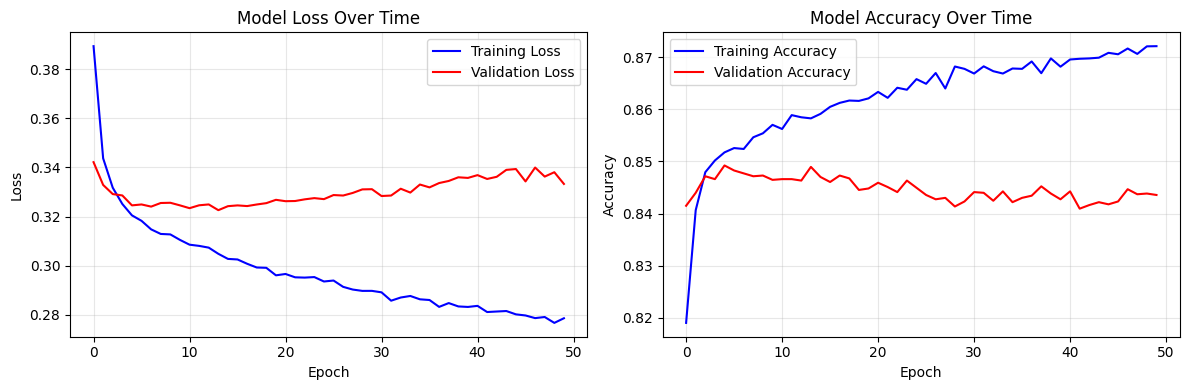

In [11]:
import matplotlib.pyplot as plt

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
ax1.plot(history.history['loss'], label='Training Loss', color='blue')
ax1.plot(history.history['val_loss'], label='Validation Loss', color='red')
ax1.set_title('Model Loss Over Time')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
ax2.set_title('Model Accuracy Over Time')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
